In [1]:
#| echo: false
#| eval: true
#|
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# setting the figure parameters
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [7, 3]
mpl.rcParams['font.size'] = 8

# Introduction
High-performance computing (HPC) has revolutionized the field of scientific research, enabling the processing of large datasets and the execution of complex simulations at unprecedented speeds. One of the key drivers of this revolution is the use of General-Purpose Graphics Processing Units (GPGPU) and the betterment of Central Processing Units (CPUs), which have significantly enhanced the computational capabilities of modern computers [@oliveira2017systematic].

This report is a product of the CUSO Informatique 2023 Winter School, where the course explored the application of parallel computing in scientific research, focusing on GPGPU and multicore computing. The winter school delved into modern and simplified approaches to parallel programming in Python, Julia, and C++ programming languages and illustrated their use in concrete research applications. The high-performance computing was complementarity to an additional lecture on deep learning.

This report focuses on the Python programming aspect of the course. More specifically, how parallelization of Python code both on the CPU and GPU can be made. To show the application of these technologies, we provide a comprehensive overview of the Expectation-Maximization (EM) algorithm, a powerful statistical technique used for finding maximum likelihood estimates in probabilistic models with latent variables. This is an interesting algorithm to explore as it is not easily parallelized due to its sequential nature. We discuss the implementation of the EM algorithm Python using different libraries that enable faster computation. We also compare the performance of these implementations, providing insights into the efficiency and effectiveness of different programming languages and computational approaches in the context of the EM algorithm.

# Literature Review
## Python and Parallelization

Despite Python's limitations due to its interpreted nature and the Global Interpreter Lock (GIL), it has become popular in scientific computing due to its extensive ecosystem of scientific libraries. The library most often used for numerical computations is *NumPy*. Practioners who use parallel computing in Python often use numpy for data processing due to its notable speed improvement. However, for parallelizing the code itself, there are two approaches; multi-threading and multi-processing. Due to the GIL, multi-threading does not lead to true parallelism and is mainly helpful for I/O-bound tasks. Conversely, multi-processing achieves true parallelism and is facilitated by Python's *multi-processing* module.

Python also supports parallel computing through third-party libraries like *Dask* and *Numba*. Dask integrates with existing Python APIs to enable parallel and larger-than-memory computations. Numba, a just-in-time (JIT) compiler, translates Python and NumPy code into fast machine code at runtime, providing parallel and GPU-accelerated computing support.

For GPU-accelerated computing, libraries such as *CuPy* and *PyTorch* (not discussed here) provide a NumPy-like API for performing computations on GPUs. Python's variety of tools and libraries for parallel and high-performance computing, combined with its simplicity and readability, make it a viable choice for scientific computing and data analysis tasks.

## Expectation Maximization (EM)
The Expectation-Maximization (EM) algorithm, introduced by @Dempster1977, is a powerful statistical technique for finding maximum likelihood estimates in probabilistic models with latent variables. The algorithm iteratively performs two steps: the Expectation (E) step, which computes the expected value of the log-likelihood function, and the Maximization (M) step, which updates the parameters to maximize this expected value. This process is repeated until convergence. In the context of this report, we focus on EM with the Gaussian Mixture Model (GMM). This probabilistic model assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. The EM algorithm can be mathematically described as follows:

1. **Expectation (E) step**: Given the current parameters of the model, the E-step computes the expected value of the log-likelihood function. In the context of a GMM, this involves calculating so-called responsibilities, which represent the probability that a particular Gaussian component generates a given data point. The responsibilities are given by:
$$
\gamma(z_{nk}) = \frac{\pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n | \mu_j, \Sigma_j)}
$$
where $\gamma(z_{nk})$ is the responsibility of the $k^{th}$ Gaussian component for the $n^{th}$ data point, $\pi_k​$ is the weight of the $k^{th}$ Gaussian component, $\mathcal{N}(x_n | \mu_k, \Sigma_k)$ is the probability density function of the $k^{th}$ Gaussian component evaluated at the $n^{th}$ data point, and $K$ is the total number of Gaussian components.

2. **Maximization (M) step**: The M-step updates the parameters of the model to maximize the expected log-likelihood found in the E-step. For a GMM, this involves updating the weights, means, and covariances of the Gaussian components based on the responsibilities calculated in the E-step. The updated parameters are given by:
$$
\mu_k^{new} = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) x_n
$$
$$
\Sigma_k^{new} = \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) (x_n - \mu_k^{new})(x_n - \mu_k^{new})^T
$$
$$
\pi_k^{new} = \frac{N_k}{N}
$$
where $N_k = \sum_{n=1}^N \gamma(z_{nk})$ is the effective number of data points assigned to the $k^{th}$ Gaussian component, $N$ is the total number of data points, and $x_n$​ is the $n^{th}$ data point. The EM algorithm alternates between the E and M steps until the parameters converge, which is typically determined by a small change in the log-likelihood from one iteration to the next.

In high-performance computing, the EM algorithm presents an interesting case study due to its iterative nature and the potential for parallelization in the E-step. Several studies have explored the parallelization of the EM algorithm, demonstrating significant speedups. For instance, @dean2008mapreduce presented a parallel implementation of the EM algorithm using the MapReduce programming model. @Lee2016 provided similar ideas for multi-threading, which require minimal changes to the sequential implementation. In another study, @zhang2010gpu proposed a GPU-based parallel EM algorithm for Gaussian Mixture Models. They demonstrated that GPU-based implementation could achieve up to 45 times faster than CPU-based.

More recently, the rise of modern programming languages like Python, Julia, and C++ has opened up new possibilities for parallel computing. These languages offer various libraries and tools for parallel programming, such as Numba, which can accelerate the EM algorithm [@chou2011fast].

# Implementation
This report will explore widely used Python-based libraries built on top of faster languages such as C++ for parallel CPU and GPU computing. The GPU implementations run on CUDA programming language, a subset of C++ used for GPU parallel computing to enhance the speed performance of the EM algorithm. The implementation of the EM algorithm is done with the following libraries:

- Vanilla (base) Python and *NumPy* for sequential execution.
- *Multi-processing* was initially experimented with for CPU-based parallel computing but was not included later in the report due to failing to achieve performance gains.
- *Numba*: A just-in-time Python compiler that provides parallelization and machine-specific optimizations.
- *CuPy* for GPU-based parallel computing.

## Data generation
We first generate some data to test our models. We want a multi-modal distribution for our data to assess how effectively EM can capture the different means and standard deviations. Additionally, a Gaussian mixture model (GMM) approach was chosen as it allows further parallelization opportunities for the data.

\scriptsize

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit, prange

# Generate data
def generate_data(n, means, stds, weights, num_mixtures, use_numpy=True):
    random.seed(0)
    if use_numpy:
        np.random.seed(0)
        mixture_idx = np.random.choice(num_mixtures, size=n, p=weights)
        y = np.fromiter((np.random.normal(means[i], stds[i]) for i in mixture_idx), dtype=np.float64)
    else:
        mixture_idx = [random.choices(range(num_mixtures), weights)[0] for _ in range(n)]
        y = [random.gauss(means[i], stds[i]) for i in mixture_idx]
    return y

\normalsize

## Vanilla Python (base)
The base Python implementation of the EM algorithm uses standard Python data structures and control flow constructs, making it easy to understand and modify. However, due to Python's interpreted nature, this implementation may not be the most efficient for large datasets or complex models. The base Python implementation serves as a reference for the more optimized versions of the algorithm implemented using libraries such as NumPy and CuPy.

In this implementation, the E-step and M-step of the EM algorithm are implemented as separate functions, `e_step_py` and `m_step_py`, respectively. The `e_step_py` function computes the responsibilities for each data point and each mixture component using a nested loop. In contrast, the `m_step_py` function updates the parameters of the mixture components based on these responsibilities. The log-likelihood of the data given the current parameters is computed in the `compute_log_likelihood_py` function. The primary `em_py` function iterates these steps until convergence, keeping track of the log-likelihood at each step to monitor the progress of the algorithm.

\scriptsize

In [3]:
# Vanilla python EM
import time
import math
# from math import pi, sqrt, exp, log

# Define a normal_pdf function
def normal_pdf(x, mean, std_dev):
    """Calculate normal density function for a given x, mean and standard deviation."""
    return (1.0 / (std_dev * ((2*math.pi)**0.5))) * math.exp(-0.5 * ((x - mean) / std_dev)**2)

def e_step_py(data, means, stds, weights, num_mixtures):
    """E-step: compute responsibilities."""
    resp = []
    for i in range(num_mixtures):
        resp.append([weights[i] * normal_pdf(d, means[i], stds[i]) for d in data])
    resp_sum = [sum(r) for r in zip(*resp)]
    resp = [[r / s for r, s in zip(resp[i], resp_sum)] for i in range(num_mixtures)]
    return resp

def m_step_py(data, resp, num_mixtures):
    """M-step: update parameters."""
    means = [sum(r * d for r, d in zip(resp[i], data)) / sum(resp[i]) for i in range(num_mixtures)]
    stds = [math.sqrt(sum(r * (d - means[i]) ** 2 for r, d in zip(resp[i], data)) / sum(resp[i])) for i in range(num_mixtures)]
    weights = [sum(r) / len(data) for r in resp]
    return means, stds, weights

def compute_log_likelihood_py(data, means, stds, weights, num_mixtures):
    """Compute the log-likelihood."""
    ll = sum(math.log(sum(weights[i] * normal_pdf(d, means[i], stds[i]) for i in range(num_mixtures))) for d in data)
    return ll


def em_py(data, means, stds, weights, num_mixtures, num_iter=100):
    """EM algorithm."""
    start_time = time.time()
    log_likelihoods = []
    for _ in range(num_iter):
        resp = e_step_py(data, means, stds, weights, num_mixtures)
        means, stds, weights = m_step_py(data, resp, num_mixtures)
        ll = compute_log_likelihood_py(data, means, stds, weights, num_mixtures)
        log_likelihoods.append(ll)
        print("Vanilla Py step", _, "Log-likelihood:", ll)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return means, stds, weights, elapsed_time, log_likelihoods

\normalsize
## Numpy
The NumPy implementation of the EM algorithm takes advantage of the efficient array operations provided by the NumPy library to speed up the computation. NumPy is a Python library that provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays. Using NumPy, we can replace explicit loops with vectorized operations implemented in compiled C code for performance.

In the NumPy implementation, the E-step and M-step are implemented in the `e_step_numpy` and `m_step_numpy` functions, respectively. These functions use NumPy's array broadcasting and aggregation functions to compute the responsibilities and update the parameters in a vectorized manner. The `compute_log_likelihood_numpy` function computes the log-likelihood of the data given the current parameters using NumPy functions. The main `em_numpy` function iterates these steps until convergence, similar to the base Python implementation. However, due to using NumPy's array operations, this implementation is expected to be significantly faster for large datasets.

\scriptsize

In [4]:
def normal_pdf(x, mean, std_dev):
    """Calculate normal density function for a given x, mean and standard deviation."""
    return (1.0 / (std_dev * ((2*np.pi)**0.5))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)

def e_step_numpy(data, means, stds, weights, num_mixtures):
    """E-step: compute responsibilities."""
    resp = np.empty((num_mixtures, len(data)))
    for i in range(num_mixtures):
        resp[i, :] = weights[i] * normal_pdf(data, means[i], stds[i])
    resp /= resp.sum(axis=0)
    return resp

def m_step_numpy(data, resp, num_mixtures):
    """M-step: update parameters."""
    means = np.sum(resp * data, axis=1) / np.sum(resp, axis=1)
    stds = np.sqrt(np.sum(resp * (data - means[:, None]) ** 2, axis=1) / np.sum(resp, axis=1))
    weights = np.mean(resp, axis=1)
    return means, stds, weights

def compute_log_likelihood_numpy(data, means, stds, weights, num_mixtures):
    """Compute the log-likelihood."""
    ll = 0
    for i in range(num_mixtures):
        ll += weights[i] * normal_pdf(data, mean=means[i], std_dev=stds[i])
    ll = np.sum(np.log(ll))
    return ll

def em_numpy(data, means, stds, weights, num_mixtures, num_iter=100, print_output=True):
    """EM algorithm."""
    start_time = time.time()
    log_likelihoods = []
    for _ in range(num_iter):
        resp = e_step_numpy(data, means, stds, weights, num_mixtures)
        means, stds, weights = m_step_numpy(data, resp, num_mixtures)
        ll = compute_log_likelihood_numpy(data, means, stds, weights, num_mixtures)
        log_likelihoods.append(ll)
        if print_output:
            print("Numpy step", _, "Log-likelihood:", ll)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return means, stds, weights, elapsed_time, log_likelihoods

\normalsize

## Numba

Numba is a just-in-time (JIT) compiler for Python that translates a subset of Python and NumPy code into fast machine code. It uses the LLVM compiler infrastructure to generate optimized machine code from pure Python. This can lead to significant performance improvements for numerical computations, particularly CPU-bound tasks.

In the context of the EM algorithm, Numba can accelerate the computation of responsibilities in the E-step and the parameter updates in the M-step. The `@njit` decorator compiles the functions that perform these computations, allowing them to be executed as fast machine code. Additionally, the `parallel=True` option enables automatic parallelization of these functions, further improving performance on multicore CPUs.

The `compute_resp` function is defined to compute the responsibilities for a single data point and mixture component. This function is then used in the `e_step_numba` and `m_step_numba` functions, which are parallelized using Numba's automatic parallelization feature. This allows the responsibilities to be computed and the parameters to be updated concurrently for different data points and mixture components, leading to a significant speedup.

The main `em_numba` function iterates the E-step and M-step until convergence or a maximum number of iterations is reached, similar to the previous implementations. However, due to the use of Numba's JIT compilation and automatic parallelization, this implementation is expected to be significantly faster, particularly for large datasets.

\scriptsize

In [5]:
#| eval: true
from numba import jit, njit, prange

@jit
def normal_pdf(x, mean, std_dev):
    """Calculate normal density function for a given x, mean and standard deviation."""
    return (1.0 / (std_dev * ((2*np.pi)**0.5))) * np.exp(-0.5 * ((x - mean) / std_dev)**2)

@jit
def compute_resp(data, means, stds, weights, i, j):
    return weights[i] * normal_pdf(data[j], means[i], stds[i])

@jit(parallel=True)
def e_step_numba(data, means, stds, weights, num_mixtures):
    resp = np.empty((num_mixtures, len(data)))
    for i in prange(num_mixtures):
        for j in range(len(data)):
            resp[i, j] = compute_resp(data, means, stds, weights, i, j)
    sum_resp = np.sum(resp, axis=0)
    for i in prange(num_mixtures):
        for j in range(len(data)):
            resp[i, j] /= sum_resp[j]
    return resp

@jit(parallel=True)
def m_step_numba(data, resp, num_mixtures):
    means = np.zeros(num_mixtures)
    stds = np.zeros(num_mixtures)
    weights = np.zeros(num_mixtures)
    for i in prange(num_mixtures):
        resp_sum = np.sum(resp[i, :])
        weighted_sum = np.sum(resp[i, :] * data)
        means[i] = weighted_sum / resp_sum
        stds[i] = np.sqrt(np.sum(resp[i, :] * (data - means[i]) ** 2) / resp_sum)
        weights[i] = resp_sum / resp.shape[1]
    return means, stds, weights

def em_numba(data, means, stds, weights, num_mixtures, num_iter=100, print_output=True):
    start_time = time.time()
    log_likelihoods = []
    for _ in prange(num_iter):
        resp = e_step_numba(data, means, stds, weights, num_mixtures)
        means, stds, weights = m_step_numba(data, resp, num_mixtures)
        ll = compute_log_likelihood_numpy(data, means, stds, weights, num_mixtures)
        log_likelihoods.append(ll)
        if print_output:
            print("Numba step", _, "Log-likelihood:", ll)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return means, stds, weights, elapsed_time, log_likelihoods

\normalsize

## CuPy

CuPy is a GPU-accelerated library for numerical computations in Python. It provides a NumPy-like API, but all computations are performed on the GPU. This allows for significant performance improvements for large-scale numerical computations, as GPUs can perform many computations concurrently.

In the context of the EM algorithm, CuPy can accelerate the computation of responsibilities in the E-step and the parameter updates in the M-step. The `normal_pdf_cupy`, `e_step_cupy`, `m_step_cupy`, and `compute_log_likelihood_cupy` functions are defined similarly to their NumPy counterparts but use CuPy functions instead of NumPy functions. This allows these computations to be performed on the GPU, leading to a significant speedup for large datasets.

The main `em_cupy` function iterates the E-step and M-step until convergence or a maximum number of iterations is reached, similar to the previous implementations. However, due to the use of CuPy's GPU-accelerated computations, this implementation is expected to be significantly faster, particularly for large datasets.

It is important to note that while CuPy can provide significant speedups for large-scale numerical computations, it also requires a compatible GPU. Furthermore, data transfer between the CPU and GPU can introduce additional overhead, limiting the speedup achievable by GPU acceleration. Therefore, it is crucial to benchmark the performance of the CuPy implementation against the other implementations for a given dataset and hardware configuration to determine the optimal approach.

\scriptsize

In [6]:
import cupy as cp

def normal_pdf_cupy(x, mean, std_dev):
    """Calculate normal density function for a given x, mean and standard deviation."""
    return (1.0 / (std_dev * ((2*cp.pi)**0.5))) * cp.exp(-0.5 * ((x - mean) / std_dev)**2)

def e_step_cupy(data, means, stds, weights, num_mixtures):
    """E-step: compute responsibilities."""
    resp = cp.empty((num_mixtures, len(data)))
    for i in range(num_mixtures):
        resp[i, :] = weights[i] * normal_pdf_cupy(data, means[i], stds[i])
    resp /= resp.sum(axis=0)
    return resp

def m_step_cupy(data, resp, num_mixtures):
    """M-step: update parameters."""
    means = cp.sum(resp * data, axis=1) / cp.sum(resp, axis=1)
    stds = cp.sqrt(cp.sum(resp * (data - means[:, None]) ** 2, axis=1) / cp.sum(resp, axis=1))
    weights = cp.mean(resp, axis=1)
    return means, stds, weights

def compute_log_likelihood_cupy(data, means, stds, weights, num_mixtures):
    """Compute the log-likelihood."""
    ll = 0
    for i in range(num_mixtures):
        ll += weights[i] * normal_pdf_cupy(data, mean=means[i], std_dev=stds[i])
    ll = cp.sum(cp.log(ll))
    return ll

def em_cupy(data, means, stds, weights, num_mixtures, num_iter=100):
    """EM algorithm."""
    start_time = time.time()
    log_likelihoods = []
    for _ in range(num_iter):
        resp = e_step_cupy(data, means, stds, weights, num_mixtures)
        means, stds, weights = m_step_cupy(data, resp, num_mixtures)
        ll = compute_log_likelihood_cupy(data, means, stds, weights, num_mixtures)
        log_likelihoods.append(ll)
        print("CuPy step", _, "Log-likelihood:", ll)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return means, stds, weights, elapsed_time, log_likelihoods

\normalsize

# Results
## Data generation
We generate the data for the means, standard deviations, and weights. The number of instances, means, standard deviations, and weights are set to generate the data. We generate data using both Python lists and NumPy arrays for comparison purposes. The generated data is visualized in a histogram, showing the distribution of data points.

\scriptsize

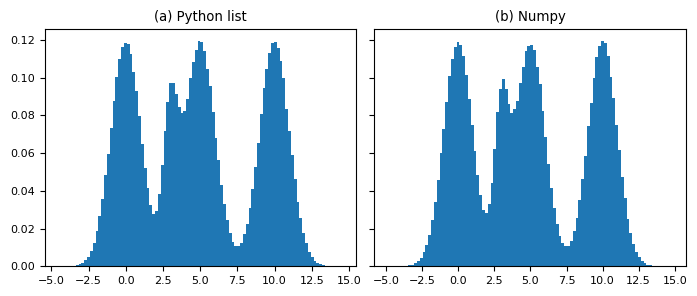

In [7]:
#| label: fig-generated-data
#| fig-cap: Generated data with 4 Gaussian mixtures
# Set the number of instances with means, stds, and weights to generate
n = 1000000
means = [0, 5, 10, 3]
stds = [1, 1, 1,0.5]
weights = [0.3, 0.3, 0.3, 0.1]
num_mixtures = len(weights)

data = generate_data(n, means, stds, weights, num_mixtures, use_numpy=False)
data_numpy = generate_data(n, means, stds, weights, num_mixtures, use_numpy=True)
data_cupy = cp.asarray(data_numpy) #only enable if you have a CUDA-enabled GPU (and imported `cupy`)

# Create subplots
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout = True)

# Draw the data for Python list
axs[0].hist(data, bins=100, density=True)
axs[0].set_title("(a) Python list")

# Draw the data for numpy
axs[1].hist(data_numpy, bins=100, density=True)
axs[1].set_title("(b) Numpy")

plt.show()

\normalsize

## Executing different implementations
We execute the EM algorithm using different implementations: vanilla Python, NumPy, Numba, and CuPy. The initial parameters for the model are set, and the EM algorithm is run for a specified number of iterations. The results, including the estimated means, standard deviations, weights, and execution time, are printed for each implementation. Here is a high-level summary of each implementation:

- Vanilla Python EM: This is the simplest form of the algorithm, implemented using basic Python data structures and operations. It is likely to be the slowest version, particularly for large datasets, as Python is an interpreted language and can be slow for large-scale numerical computation.

- NumPy: This version replaces Python lists with NumPy arrays and uses NumPy operations for the E-step and M-step. Since NumPy operations are implemented in C and can take advantage of vectorized operations, this version should be much faster than the vanilla Python version.

- Numba: This version uses the Numba library to compile the E-step and M-step functions to machine code at runtime (a process known as 'just-in-time' compilation). This should make these functions much faster, particularly for large datasets.

- CuPy: This version replaces NumPy arrays with CuPy arrays, which are similar but run on a GPU instead of a CPU. This means the algorithm can take advantage of the massively parallel architecture of modern GPUs, which should be significantly faster than any CPU-based version for large datasets. Please note that the GPU-based version (CuPy) requires a compatible NVIDIA GPU and the CUDA toolkit to be installed on the machine running the code. Additionally, not all operations might be faster on GPU due to the overhead of moving data between the CPU and GPU. It is usually beneficial when the computational cost is high, and the data can be processed in parallel.

To test our implementations, we first initialize some information for the model parameters:

\scriptsize

In [8]:
# Initial parameters
means_init = [-1, -3, 11, 4]
stds_init = [1, 1, 1, 0.5]
parts = len(means_init)
weights_init = [(1/parts)] * parts
num_iter = 10

\normalsize

Please note that we use Python lists and not Numpy arrays for the base Python implementation to ensure that the comparison is fair.

\scriptsize

In [9]:
# Run EM algorithm with vanilla Python
means_py, stds_py, weights_py, elapsed_time_py, log_likelihoods_py = em_py(
    data, means_init, stds_init, weights_init, num_mixtures, num_iter
)

# Make the initial means also into NumPy arrays
means_init = np.array(means_init)
stds_init = np.array(stds_init)
weights_init = np.array(weights_init)

# Run EM algorithm with Numpy
means_numpy, stds_numpy, weights_numpy, elapsed_time_numpy, log_likelihoods_numpy = em_numpy(
    data_numpy[:100], means_init, stds_init, weights_init, num_mixtures, num_iter,
    print_output=False
)

means_numpy, stds_numpy, weights_numpy, elapsed_time_numpy, log_likelihoods_numpy = em_numpy(
    data_numpy, means_init, stds_init, weights_init, num_mixtures, num_iter
)

# Run EM algorithm with Numba
# Warm-up run
means_numba, stds_numba, weights_numba, elapsed_time_numba, log_likelihoods_numba = em_numba(
    data_numpy[:100], means_init, stds_init, weights_init, num_mixtures, num_iter, print_output=False
)

means_numba, stds_numba, weights_numba, elapsed_time_numba, log_likelihoods_numba = em_numba(
    data_numpy, means_init, stds_init, weights_init, num_mixtures, num_iter
)

# Run EM algorithm with CuPy (only works with CUDA-enabled GPU)
means_cupy, stds_cupy, weights_cupy, elapsed_time_cupy, log_likelihoods_cupy = em_cupy(
    data_cupy, means_init, stds_init, weights_init, num_mixtures, num_iter
)

print("-" * 50)

# Print results
print("Python:\n\tmeans =", means_py, "\n\tstds =", stds_py, "\n\tweights =", weights_py,
      "\n\ttime =", elapsed_time_py, "s")

print("Numpy:\n\tmeans =", means_numpy, "\n\tstds =", stds_numpy, "\n\tweights =", weights_numpy,
      "\n\ttime =", elapsed_time_numpy, "s")

print("Numba:\n\tmeans =", means_numba, "\n\tstds =", stds_numba, "\n\tweights =", weights_numba,
      "\n\ttime =", elapsed_time_numba, "s")

print("CuPy:\n\tmeans =", means_cupy, "\n\tstds =", stds_cupy, "\n\tweights =", weights_cupy,
      "\n\ttime =", elapsed_time_cupy, "s")

Vanilla Py step 0 Log-likelihood: -2582154.77915232
Vanilla Py step 1 Log-likelihood: -2564856.1762425895
Vanilla Py step 2 Log-likelihood: -2557584.567868932
Vanilla Py step 3 Log-likelihood: -2555382.033204309
Vanilla Py step 4 Log-likelihood: -2554632.264487238
Vanilla Py step 5 Log-likelihood: -2554285.7716815015
Vanilla Py step 6 Log-likelihood: -2554092.1019310234
Vanilla Py step 7 Log-likelihood: -2553973.2082615434
Vanilla Py step 8 Log-likelihood: -2553896.8185001
Vanilla Py step 9 Log-likelihood: -2553846.817178973
Numpy step 0 Log-likelihood: -2581404.261439712
Numpy step 1 Log-likelihood: -2564104.366757368
Numpy step 2 Log-likelihood: -2556997.094354966
Numpy step 3 Log-likelihood: -2554859.3549245144
Numpy step 4 Log-likelihood: -2554117.8439922445
Numpy step 5 Log-likelihood: -2553769.4140029433
Numpy step 6 Log-likelihood: -2553573.186908773
Numpy step 7 Log-likelihood: -2553452.491059332
Numpy step 8 Log-likelihood: -2553375.025107684
Numpy step 9 Log-likelihood: -2553

\normalsize

## Visualizations

We visualize the convergence of the EM algorithm by plotting the log-likelihood against the number of iterations. @fig-converge shows that the algorithm slowly converges, and there is no significant difference in the log-likelihood between the different implementations. In terms of time, we see that numpy significantly increases performance. Then, using NumPy, the numba approach shows even further improvement. It must be noted that Numba is significantly faster than the other techniques, which comes by adding the `@jit` decorators and the `parallel=True` to existing functions to enable machine-optimized and parallelized execution.

\scriptsize

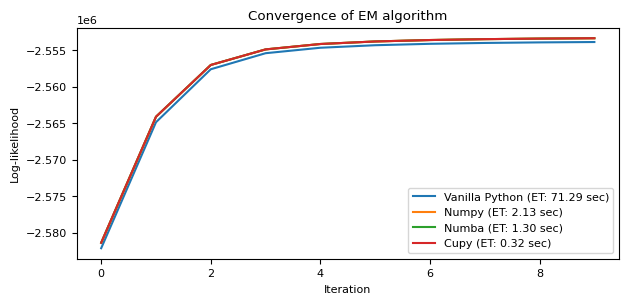

In [48]:
#| label: fig-converge
#| fig-cap: Log-likelihood and time convergence of the different algorithms
# Plot the convergence
plt.plot(log_likelihoods_py, label=f'Vanilla Python (ET: {elapsed_time_py:.2f} sec)')
plt.plot(log_likelihoods_numpy, label=f'Numpy (ET: {elapsed_time_numpy:.2f} sec)')
plt.plot(log_likelihoods_numba, label=f'Numba (ET: {elapsed_time_numba:.2f} sec)')
log_likelihoods_cupy_np = [item.get() for item in log_likelihoods_cupy]
plt.plot(log_likelihoods_cupy_np, label=f'Cupy (ET: {elapsed_time_cupy:.2f} sec)')
plt.title('Convergence of EM algorithm')
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.legend()
plt.show()

\normalsize

We also compare the actual and estimated probability density functions (PDFs) for the different implementations (@fig-predicted-dist). The plots show that all implementations produce similar estimates, confirming the correctness of the implementations.

\scriptsize

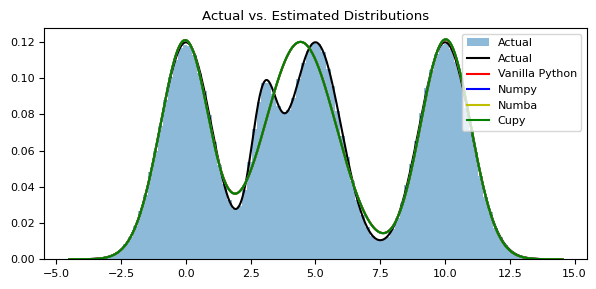

In [49]:
#| label: fig-predicted-dist
#| fig-cap: Actual vs predicted distributions

from scipy.stats import norm

# Compute the actual and estimated PDFs
x = np.linspace(min(data), max(data), 1000)
pdf_actual = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means, stds, weights))
pdf_py = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means_py, stds_py, weights_py))
pdf_numpy = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means_numpy, stds_numpy, weights_numpy))
pdf_numba = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means_numba, stds_numba, weights_numba))
means_cupy = cp.asnumpy(means_cupy)
stds_cupy = cp.asnumpy(stds_cupy)
weights_cupy = cp.asnumpy(weights_cupy)
pdf_cupy = sum(w * norm.pdf(x, m, s) for m, s, w in zip(means_cupy, stds_cupy, weights_cupy))

# Plot the actual and estimated PDFs
plt.hist(data, bins=100, density=True, alpha=0.5, label='Actual')
plt.plot(x, pdf_actual, 'k-', label='Actual')
plt.plot(x, pdf_py, 'r-', label='Vanilla Python')
plt.plot(x, pdf_numpy, 'b-', label='Numpy')
plt.plot(x, pdf_numba, 'y-', label='Numba')
plt.plot(x, pdf_cupy, 'g-', label='Cupy')
plt.title('Actual vs. Estimated Distributions')
plt.legend()
plt.show()

\normalsize

As we could not test the CuPy approach locally, the same notebook was re-created on Google Colab, which provides CUDA-enabled GPUs. The results from FIGURE show that the speed gain can remarkably improve if adequate hardware is available. From a software standpoint, this requires some changes from NumPy to CuPy; however, as the syntax is very close, the required changes are negligible.

# Conclusion

In this report, we have explored the Expectation-Maximization (EM) algorithm for Gaussian Mixture Models and implemented it using various Python libraries to optimize its performance. The vanilla Python implementation, while being the most straightforward, was also the slowest due to Python's interpreted nature and lack of vectorized operations. The NumPy implementation improved upon this by utilizing vectorized operations and C-optimized computations, resulting in a significant speedup. The Numba implementation, which uses just-in-time compilation to optimize the runtime code, provided further speed improvements. Finally, we explored using CuPy, a GPU-accelerated library, for numerical computations. While we did not run the CuPy code locally due to hardware constraints, the Google Colab results showed that it provides significant speedups for large datasets due to the massively parallel architecture of modern GPUs.

In conclusion, while the optimal approach depends on the specific dataset and hardware configuration, this report demonstrates the potential for significant performance improvements in the EM algorithm using optimized Python libraries and parallel computing techniques. Our parallelization may not be optimal, and adapting other implementations, such as @Lee2016, can help improve the results. Lastly, it is essential to benchmark different approaches with a different number of observations and parameters to evaluate the consistency of the results.